# MNIST: Fully Connected network

In [1]:
import numpy, torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib.colors import Colormap

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:
train = MNIST('/tmp/data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization 
]), )

test = MNIST('/tmp/data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

Processing...
Done!


In [3]:
class Model(nn.Module):
    """
    Fully-connected model, with one hidden layer.
    
    Attributes
    ----------
    fc : torch.nn.modules.linear.Linear
        The first fully-connected layer.
    fc2 : torch.nn.modules.linear.Linear
        The second fully connected layer.
    
    Examples
    --------
    >>> model = Model()
    >>> if cuda:
    ...     model.cuda()
    >>>> optimizer = optim.Adam(model.parameters(), lr=1e-3)
    """
    def __init__(self):
        """
        Creation of the model.
        """
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        """
        A forward pass in the model.
        
        Parameters
        ----------
        x : torch.nn_like
            The input of the model.
        
        Returns
        -------
        out : torch.nn_like
            The output of the model.
        
        Notes
        -----
        This function as not to be call directly.
        """
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=0)    
    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
EPOCHS = 5
losses = []

# Eval
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
train_size = len(train_loader.dataset)
batch_size = (train_size / 256) if (cuda) else  (train_size / 64)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')

    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.091126	 Test Accuracy: 96.7100%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.159133	 Test Accuracy: 96.7600%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.235586	 Test Accuracy: 97.2600%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.108007	 Test Accuracy: 97.9200%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.013668	 Test Accuracy: 98.2300%


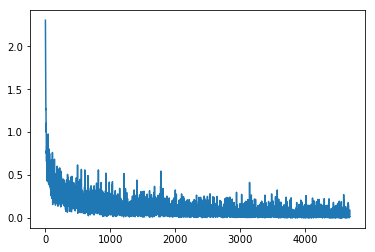

In [5]:
plt.plot(losses)

In [6]:
model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]
print('Accuracy: {}%'.format(accuracy*100))

Accuracy: 98.22999999999999%
